<IPython.core.display.Javascript object>


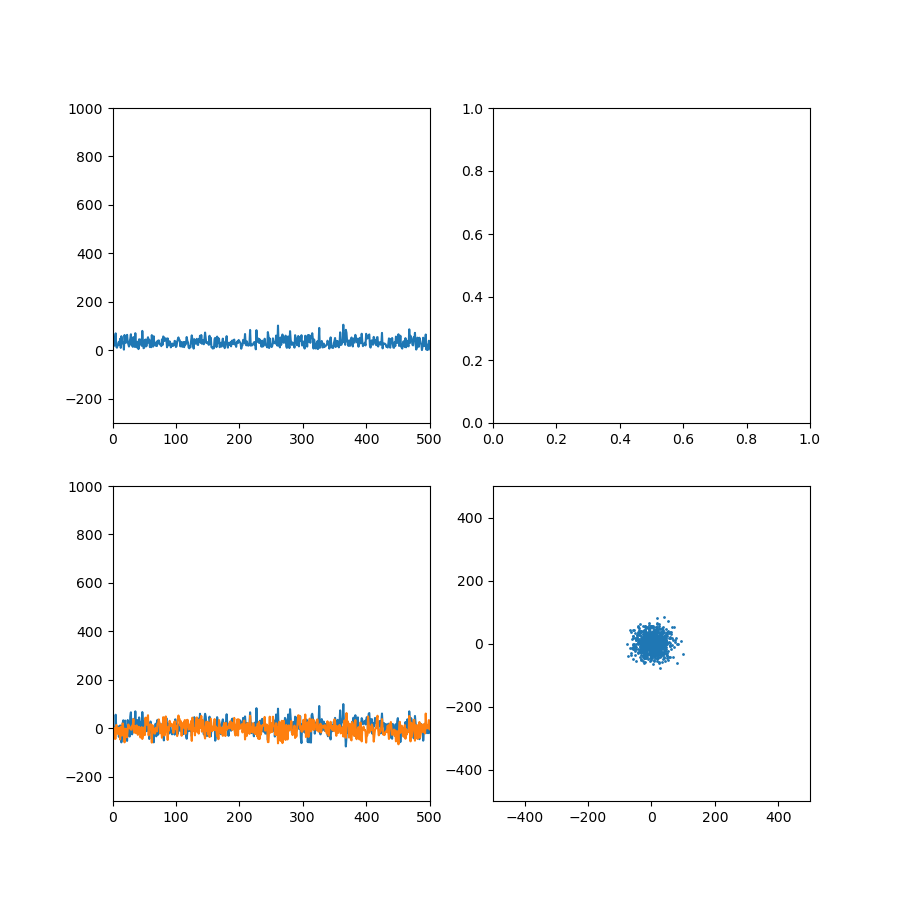

In [9]:
%matplotlib notebook

from random import randint

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import adi
import numpy as np

sdr = adi.Pluto('ip:192.168.2.1') # адрес PlutoSDR
sdr.sample_rate = int(2.5e6)


# create empty lists for the x and y data
x_0 = []
y_0 = []

x_1 = []
y_1 = []

x_2 = []
y_2 = []

x_3 = []
y_3 = []

x_4 = []
y_4 = []

# create the figure and axes objects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
x_limit = 500
y_limit = 1000
def animate(j):
    rx_data = sdr.rx()
    ifft = np.fft.ifft(rx_data)

    for i in range(len(rx_data)):
        x_0.append(i)
        y_0.append(abs(rx_data[i]))
        
        x_1.append(i)
        y_1.append(rx_data[i].real)
        y_2.append(rx_data[i].imag)
        
        x_3.append(rx_data[i].real)
        y_3.append(rx_data[i].imag)
        
        x_4.append(i)
        y_4.append(abs(ifft[i]))
    

    axs[0, 0].clear()
    axs[0, 0].plot(x_0, y_0)
    axs[0, 0].set_xlim([0,x_limit])
    axs[0, 0].set_ylim([-300,y_limit])
    x_0.clear()
    y_0.clear()
    
    axs[1, 0].clear()
    axs[1, 0].plot(x_1, y_1, x_1, y_2)
    axs[1, 0].set_xlim([0,x_limit])
    axs[1, 0].set_ylim([-300,y_limit])
    x_1.clear()
    y_1.clear()
    y_2.clear()
    
    axs[1, 1].clear()
    axs[1, 1].scatter(x_3, y_3, s=1)
    axs[1, 1].set_xlim([-x_limit,x_limit])
    axs[1, 1].set_ylim([-y_limit/2,y_limit/2])
    x_3.clear()
    y_3.clear()
    
    axs[0, 1].clear()
    axs[0, 1].plot(x_4, y_4, usevlines=True, maxlags=50, normed=True, lw=2)
    axs[0, 1].set_xlim([0,100])
    axs[0, 1].set_ylim([-1,1])
    x_4.clear()
    y_4.clear()
    
# run the animation
ani = FuncAnimation(fig, animate, frames=20, interval=500, repeat=True)

plt.show()

tx samples:  [ 11585.23750296+11585.23750296j  11585.23750296+11585.23750296j
  11585.23750296+11585.23750296j ... -11585.23750296-11585.23750296j
 -11585.23750296-11585.23750296j -11585.23750296-11585.23750296j]
rx_len:  100000
rx_samples:  [-4.-25.j -4.-25.j -4.-25.j ... 26. -5.j 26. -5.j 26. -5.j]


<IPython.core.display.Javascript object>


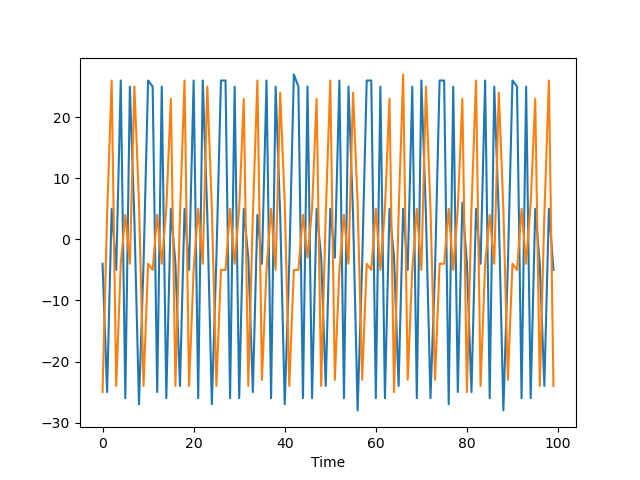

<IPython.core.display.Javascript object>


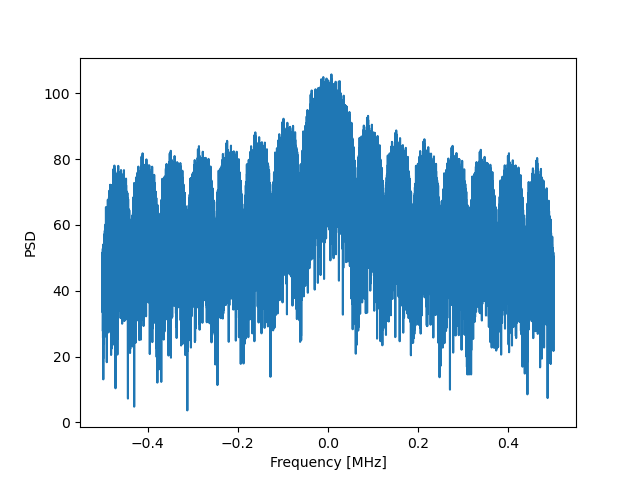

In [2]:
import numpy as np
import adi
import matplotlib.pyplot as plt

sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -20 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Create transmit waveform (QPSK, 16 samples per symbol)
num_symbols = 1000
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
samples = np.repeat(x_symbols, 16) # 16 samples per symbol (rectangular pulses)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(samples) # start transmitting
print("tx samples: ", samples)

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print("rx_len: ",len(rx_samples))
print("rx_samples: ",rx_samples)

# Stop transmitting
sdr.tx_destroy_buffer()

# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot time domain
plt.figure(0)
plt.plot(np.real(rx_samples[::1000]))
plt.plot(np.imag(rx_samples[::1000]))
plt.xlabel("Time")

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()

[16384.            +0.j         16382.86303472  +193.01498776j
 16379.45229669  +386.00318703j ...  -578.93781304-16373.76825928j
  -386.00318703-16379.45229669j  -193.01498776-16382.86303472j]
rx_len:  100000
rx_samples:  100000


<IPython.core.display.Javascript object>


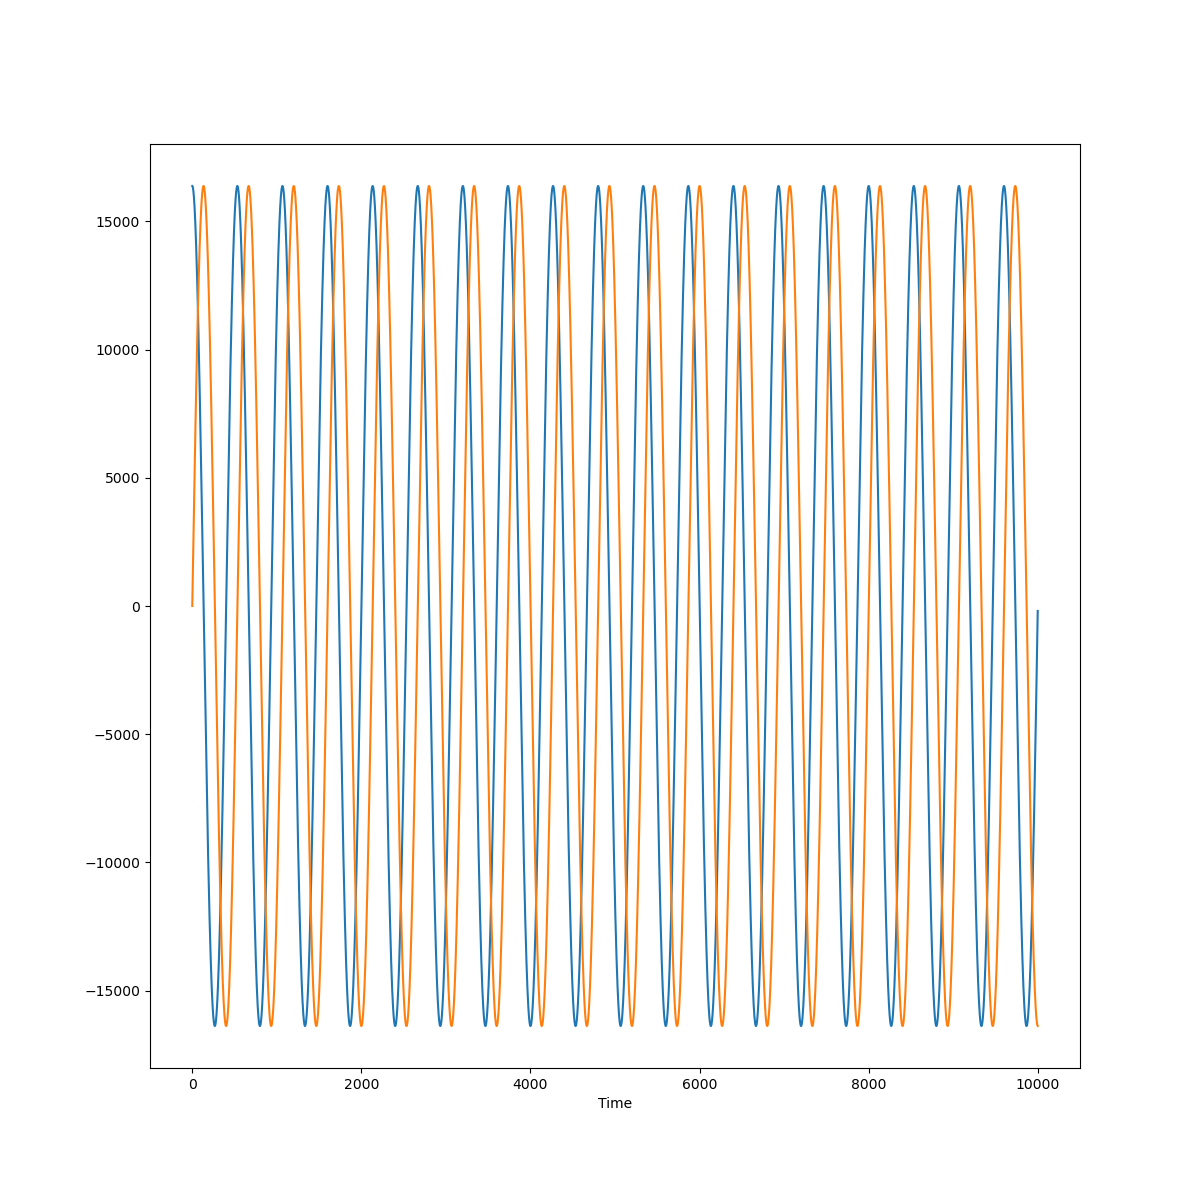

<IPython.core.display.Javascript object>


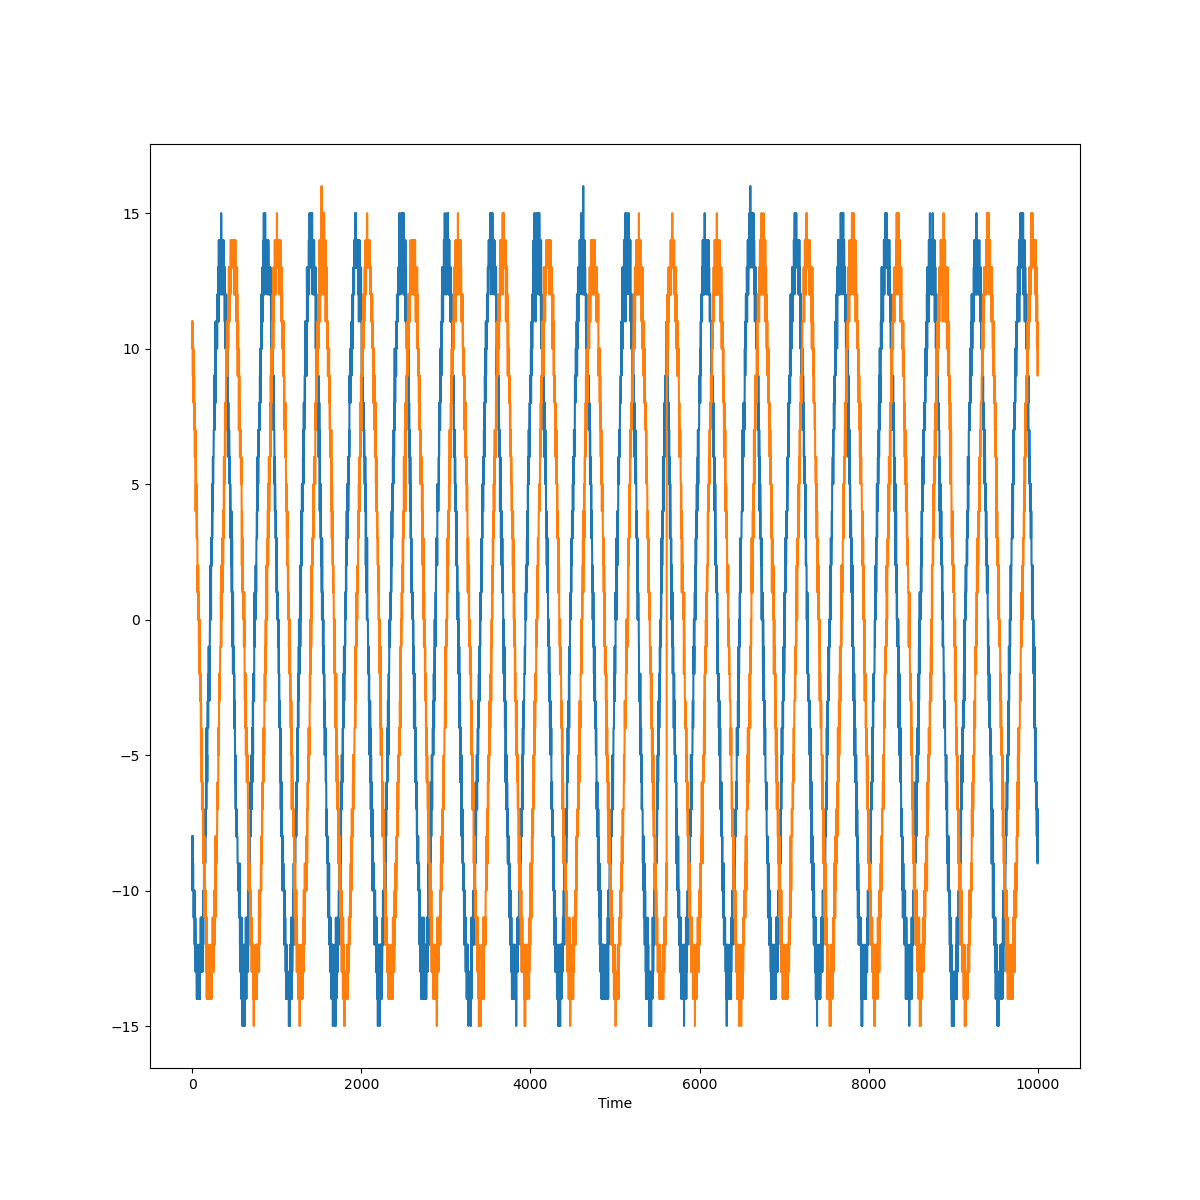

<IPython.core.display.Javascript object>


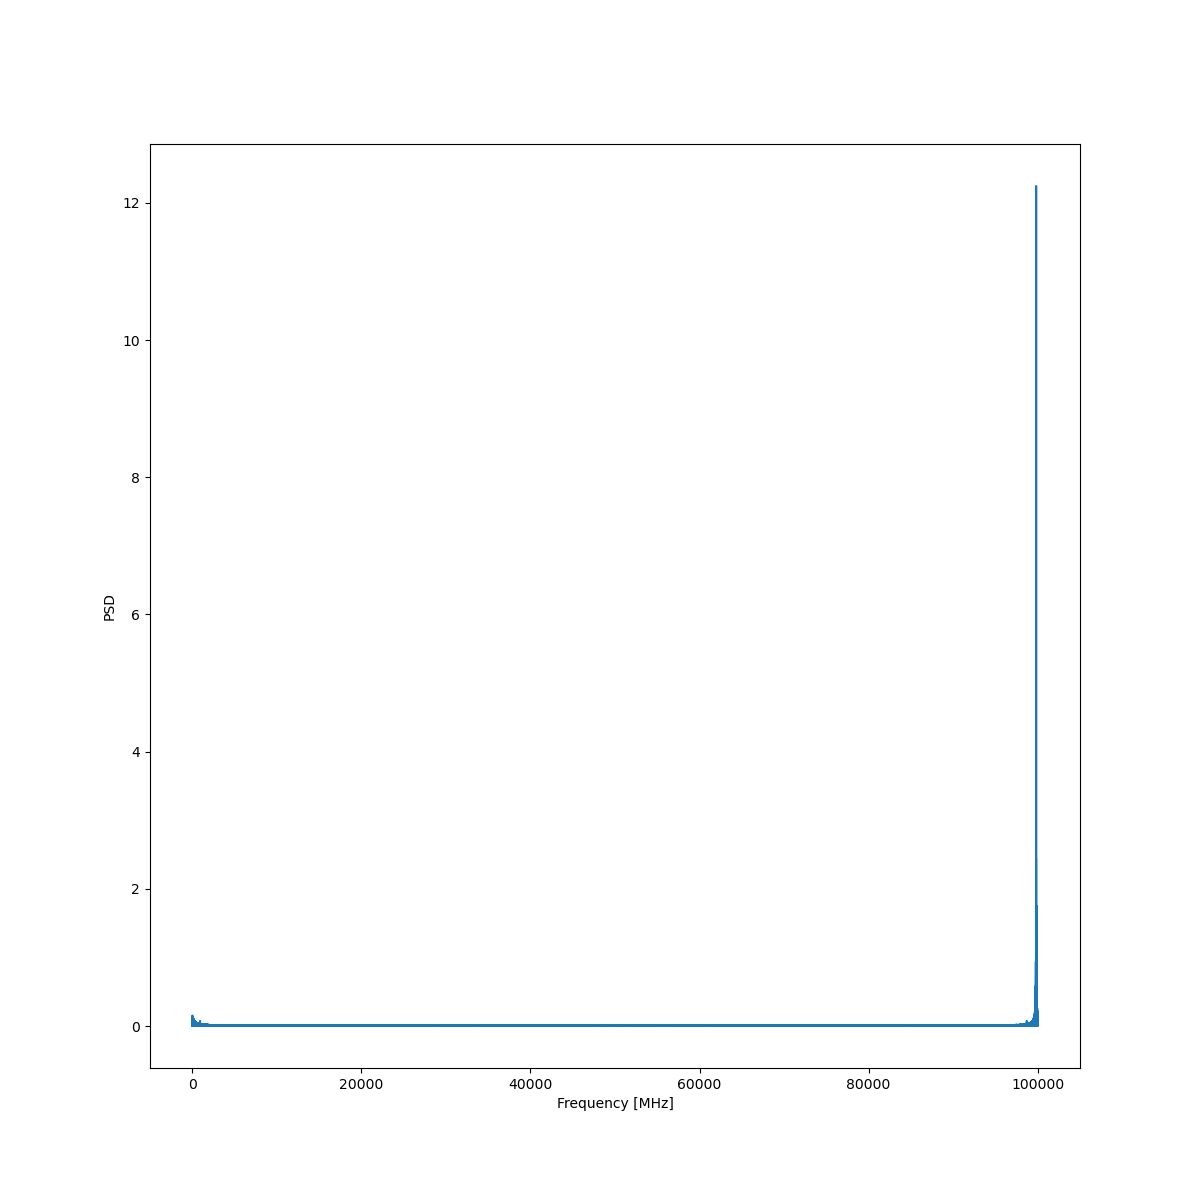

In [10]:
import numpy as np
import adi
import matplotlib.pyplot as plt


# Попробуем отправить просто 1 синусоиду и принять ее же
sample_rate = 4e6 # Hz ширина полосы
center_freq = 2000e6 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -20 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual' #fast_attack, slow_attack
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Create transmit waveform (QPSK, 16 samples per symbol)
# num_symbols = 1000
# x_int = np.zeros(num_symbols) # 0 to 3
# x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
# x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
# x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
# print("x_symbols len: ", len(x_symbols))
# samples = np.repeat(x_symbols, 1) # 16 samples per symbol (rectangular pulses)
# print("samples len: ", len(samples))
# samples = x_symbols
# samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs
# 15 разрядов
num_symbols = 10000
fs = sample_rate
fc = int(3000000 / (fs / num_symbols))
ts = 1 / float(fs)
t = np.arange(0, num_symbols * ts, ts)
i = np.cos(2 * np.pi * t * fc) * 2 ** 14
q = np.sin(2 * np.pi * t * fc) * 2 ** 14
samples = i + 1j * q

print(samples)

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
#while(1):
sdr.tx(samples) # start transmitting
#print("tx samples: ", samples)

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print("rx_len: ",len(rx_samples))
print("rx_samples: ",len(rx_samples))

# Stop transmitting
sdr.tx_destroy_buffer()

# Calculate power spectral density (frequency domain version of signal)
#psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
#psd_dB = 10*np.log10(psd)
#f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))
ifft = np.abs(np.fft.ifft(rx_samples))

# Plot time domain
plt.figure(0, figsize=(12, 12))
plt.plot(np.real(samples))
plt.plot(np.imag(samples))
#plt.plot(np.abs(rx_samples))
plt.xlabel("Time")

# Plot time domain
plt.figure(1, figsize=(12, 12))
plt.plot(np.real(rx_samples[:10000]))
plt.plot(np.imag(rx_samples[:10000]))
#plt.plot(np.abs(rx_samples))
plt.xlabel("Time")

# Plot freq domain
plt.figure(2, figsize=(12, 12))
plt.plot(ifft)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()


In [2]:
import adi
import numpy as np
import pygame
from matplotlib import mlab as mlab
from PIL import Image

DISPLAY_WIDTH = 500
DISPLAY_HEIGHT = 600

sdr = adi.Pluto("ip:192.168.3.1")
# configure device
sdr.sample_rate = int(20e6)  # Hz
sdr.rx_lo = int(2400e6)  # Hz
sdr.tx_lo = int(1e9)  # Hz
sdr.gain_control_mode_chan0 = "slow_attack"
sdr.rx_buffer_size = 16 * 1024
sdr.dds_enabled = [1, 1, 1, 1]
sdr.dds_frequencies = [1e6, 1e6, 1e6, 1e6]
sdr.dds_scales = [1, 1, 0, 0]

image = []


def get_data():
    samples = sdr.rx()
    power, _ = mlab.psd(samples, NFFT=2048, Fs=int(sdr.sample_rate) / 1e6)

    max_pow = 0
    min_pow = 10

    # search whole data set for maximum and minimum value
    for dat in power:
        if dat > max_pow:
            max_pow = dat
        elif dat < min_pow:
            min_pow = dat

    # update image data
    imagelist = []
    for dat in power:
        imagelist.append(mymap(dat, min_pow, max_pow, 0, 255))
    image.append(
        imagelist[
            round(len(imagelist) / 2)
            - round(len(imagelist) / 8) : round(len(imagelist) / 2)
            + round(len(imagelist) / 8)
        ]
    )
    if len(image) > 600:
        image.pop(0)


def mymap(x, in_min, in_max, out_min, out_max):
    return [int((x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min), 55]


pygame.init()
gameDisplay = pygame.display.set_mode((DISPLAY_WIDTH, DISPLAY_HEIGHT))
pygame.display.set_caption(f"DIY SDR with PlutoSDR")
clock = pygame.time.Clock()
background = pygame.Surface(gameDisplay.get_size())
background = background.convert()
background.fill((0, 0, 0))

game_quit = False

while not game_quit:

    
    gameDisplay.blit(background, (0, 0))

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            game_quit = True

    get_data()
    outimage = np.array(image, np.ushort)
    outimage = Image.fromarray(outimage, mode="RGB")
    outimage = outimage.convert("RGBA")
    strFormat = "RGBA"
    raw_str = outimage.tobytes("raw", strFormat)
    surface = pygame.image.fromstring(raw_str, outimage.size, "RGBA")
    gameDisplay.blit(surface, (0, 0))
    pygame.display.update()
    clock.tick(60)

pygame.quit()

try:
    pass
except KeyboardInterrupt:
    pass
finally:
    sdr = []  # type: ignore

In [1]:
import numpy as np
bit_array = np.random.randint(0, 2, 2048)

In [4]:

def qpsk_modulation(array):
    modulated = []
    real = 0
    imag = 0
    const = 2**14
    for i in range(0, len(array), 2):
        if(array[i] == 0):
            real = -0.7 * const
        elif (array[i] == 1):
            real = 0.7 * const
        if(array[i+1] == 0):
            imag = -0.7 * const
        elif(array[i+1] == 1):
            imag = 0.7 * const
        modulated.append(complex(real, imag))
    return modulated

def qpsk_demodulation(complex_array):
    bits = []
    (-0.5 +0.9j)
    for i in complex_array:
        if(i.real > 0):
            bits.append(1)
        elif(i.real <= 0):
            bits.append(0)
        if(i.imag > 0):
            bits.append(1)
        elif(i.imag <= 0):
            bits.append(0)
    return bits

import numpy as np
import adi
import matplotlib.pyplot as plt


# Попробуем отправить просто 1 синусоиду и принять ее же
sample_rate = 1e6 # Hz ширина полосы
center_freq = 915e6 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = 0 # Increase to increase tx power, valid range is -90 to 0 dB

num_symbols = 100000
bit_array = np.ones(num_symbols)
# fs = sample_rate
# fc = int(3000000 / (fs / num_symbols))
# ts = 1 / float(fs)
# t = np.arange(0, num_symbols * ts, ts)

print(bit_array)
modulated = qpsk_modulation(bit_array)
samples = modulated #np.fft.ifft(modulated)

# Start the transmitter
#sdr.tx_cyclic_buffer = True # Enable cyclic buffers
while(1):
    sdr.tx(samples) # start transmitting


[1. 1. 1. ... 1. 1. 1.]


KeyboardInterrupt: 

In [4]:
import adi

sdr_1 = adi.Pluto('ip:192.168.2.1') # адрес PlutoSDR 1
sdr_2 = adi.Pluto('ip:192.168.3.1') # адрес PlutoSDR 2

In [5]:
import adi
import numpy as np

sdr = adi.Pluto('ip:192.168.2.1') # адрес PlutoSDR
sdr.sample_rate = int(2.5e6)
sdr.rx()

array([1.-1.j, 0.-1.j, 3.-2.j, ..., 0.-2.j, 3.-2.j, 2.-2.j])